In [2]:
import pandas as pd
import glob 
import statsmodels.api as sm
import numpy as np

In [80]:
# read all  parquet files in the folder and store them in a dataframe
df = pd.concat([pd.read_parquet(f) for f in glob.glob(r'C:\Users\nasta\OneDrive - TU Eindhoven\Desktop\DCIA\DCIA\Data-20230329T105410Z-001\Data\*.parquet')], ignore_index = True)
df['date_code'] = pd.to_datetime(df['date_code'], format='%Y%m%d',errors='coerce')
df.sort_values(by=['date_code'],inplace=True)
df.set_index('date_code')

,store_code,period_code,redeemer_latest_ind,customer_code,customer_segment_level_1_code,customer_segment_level_2_code,revenue_after_discount_incl_vat,quantity_sold,store_type_new
date_code,,,,,,,,,
2020-06-29,212,1,0,946530,1.0,1.0,2188.0,5.718,Hypermarket
2020-06-29,365,1,1,1433460,1.0,1.0,2312.0,12.234,Hypermarket
2020-06-29,279,1,1,17980,3.0,6.0,2838.0,15.864,Hypermarket
2020-06-29,323,1,1,1365490,1.0,1.0,3156.0,12.594,Daily
2020-06-29,256,1,0,932800,3.0,6.0,310.0,2.000,Hypermarket
...,...,...,...,...,...,...,...,...,...
2022-04-03,297,4,1,1183790,1.0,1.0,5702.7,13.315,Online
2022-04-03,254,4,0,1382000,3.0,6.0,1179.0,5.000,Hypermarket
2022-04-03,417,4,0,1032270,2.0,2.0,3596.0,12.000,Daily


In [4]:
#split df into two dataframes, one for period_code = 3 and 4 and one for period_code = 1 and 2
df_1 = df[df['period_code']==1]
df_2 = df[df['period_code']==2]
df_3 = df[df['period_code']==3]
df_4 = df[df['period_code']==4]

#indicate whater the point is in LP period or not 
df_2['LP'] = 1
df_4['LP'] = 1
df_1['LP'] = 0
df_3['LP'] = 0

existing_customers = pd.concat([df_1['customer_code'], df_2['customer_code'], df_3['customer_code']])
df_4['new_customer'] = ~df_4['customer_code'].isin(existing_customers)*1

C:\Users\nasta\AppData\Local\Temp\ipykernel_16112\870439524.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['LP'] = 1
C:\Users\nasta\AppData\Local\Temp\ipykernel_16112\870439524.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['LP'] = 1
C:\Users\nasta\AppData\Local\Temp\ipykernel_16112\870439524.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Preprocessing...

In [62]:
# Create a new DataFrame with the necessary columns
new_df = df[['date_code', 'period_code', 'customer_code', 'revenue_after_discount_incl_vat']]

# Aggregate the data by date and period
new_df = new_df.groupby(['date_code', 'period_code']).agg({'customer_code': 'count', 'revenue_after_discount_incl_vat': 'sum'})

# Rename the aggregated columns
new_df = new_df.rename(columns={'customer_code': 'num_customers', 'revenue_after_discount_incl_vat': 'total_revenue'})

# Create a new DataFrame with the necessary columns
week_df = df[['date_code', 'period_code']]

# Get the start date for each period
start_dates = week_df.groupby('period_code').agg({'date_code': 'min'})

# Create a dictionary mapping period codes to start dates
start_date_dict = start_dates.to_dict()['date_code']

# Define a function to calculate the week number for a given date and period
def get_week(date, period):
    start_date = start_date_dict[period]
    days_since_start = (date - start_date).days
    week = (days_since_start // 7) + 1
    return week

# Define a function to calculate the day number for a given date and period
def get_day(date, period):
    start_date = start_date_dict[period]
    days_since_start = (date - start_date).days
    return days_since_start


#Apply the get_week function to each row in the DataFrame
week_df['week'] = week_df.apply(lambda x: get_week(x['date_code'], x['period_code']), axis=1)

#Apply the get_day function to each row in the DataFrame
week_df['day'] = week_df.apply(lambda x: get_day(x['date_code'], x['period_code']), axis=1)


# Merge the week column back into the new_df DataFrame
new_df = pd.merge(new_df, week_df[['date_code', 'period_code', 'week', 'day']], on=['date_code', 'period_code'])

# Reset the index to create separate columns for date and period
new_df = new_df.reset_index()

new_df['treatment'] = ((new_df['period_code'] == 3) | (new_df['period_code'] == 4)).astype(int)

# create a binary indicator column for the post-treatment period
new_df['post'] = ((new_df['period_code'] == 2) | (new_df['period_code'] == 4)).astype(int)


# create an interaction term between treatment and post
new_df['treatment_post'] = new_df['treatment'] * new_df['post']


# create an interaction term between week and post
new_df['week_post'] = new_df['post'] * new_df['week']
new_df['week_post_treatment'] = new_df['post'] * new_df['week'] * new_df['treatment']

#make a dummyfy the varaible week_post
#new_df = pd.get_dummies(new_df, columns=['week'])



C:\Users\nasta\AppData\Local\Temp\ipykernel_16112\2562439170.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_df['week'] = week_df.apply(lambda x: get_week(x['date_code'], x['period_code']), axis=1)
C:\Users\nasta\AppData\Local\Temp\ipykernel_16112\2562439170.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_df['day'] = week_df.apply(lambda x: get_day(x['date_code'], x['period_code']), axis=1)


Difference in differences for total revenue and number of customers per day

In [9]:

# fit a linear regression model with the interaction term and other covariates
X = new_df[['post', 'treatment','treatment_post', 'week_post','week_post_treatment']]
X = sm.add_constant(X)
y = new_df['num_customers']
model = sm.OLS(y, X).fit()

# print the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          num_customers   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                 1.878e+04
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:45:25   Log-Likelihood:            -2.5766e+07
No. Observations:             3252967   AIC:                         5.153e+07
Df Residuals:                 3252961   BIC:                         5.153e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5981.5603    

In [18]:

# fit a linear regression model with the interaction term and other covariates
X = new_df[['post', 'treatment','treatment_post', 'week_post','week_post_treatment']]
X = sm.add_constant(X)
y = new_df['total_revenue'] 
model = sm.OLS(y, X).fit()

# print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                 7.741e+04
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:53:29   Log-Likelihood:            -5.4846e+07
No. Observations:             3252967   AIC:                         1.097e+08
Df Residuals:                 3252961   BIC:                         1.097e+08
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.475e+07   5

Exploration for model intrepretation


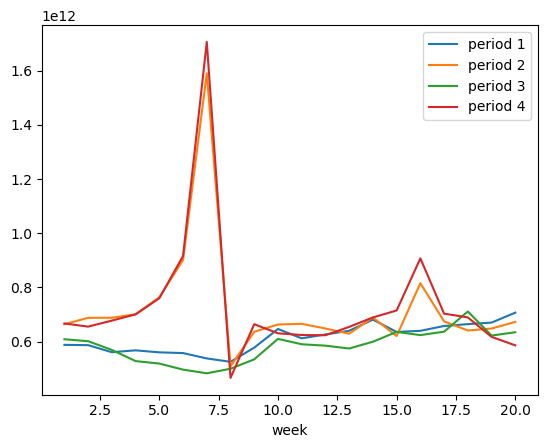

In [64]:
#plot bar chart of revenue per period
#new_df.groupby('period_code')['total_revenue'].sum().plot(kind='bar')
import matplotlib.pyplot as plt
#plot total revenu per day in a line chart
new_df[new_df['period_code']==1].groupby(['week'])['total_revenue'].sum().plot(kind='line')
new_df[new_df['period_code']==2].groupby(['week'])['total_revenue'].sum().plot(kind='line')
new_df[new_df['period_code']==3].groupby(['week'])['total_revenue'].sum().plot(kind='line')
new_df[new_df['period_code']==4].groupby(['week'])['total_revenue'].sum().plot(kind='line')
#add legend
plt.legend(['period 1', 'period 2', 'period 3', 'period 4'])


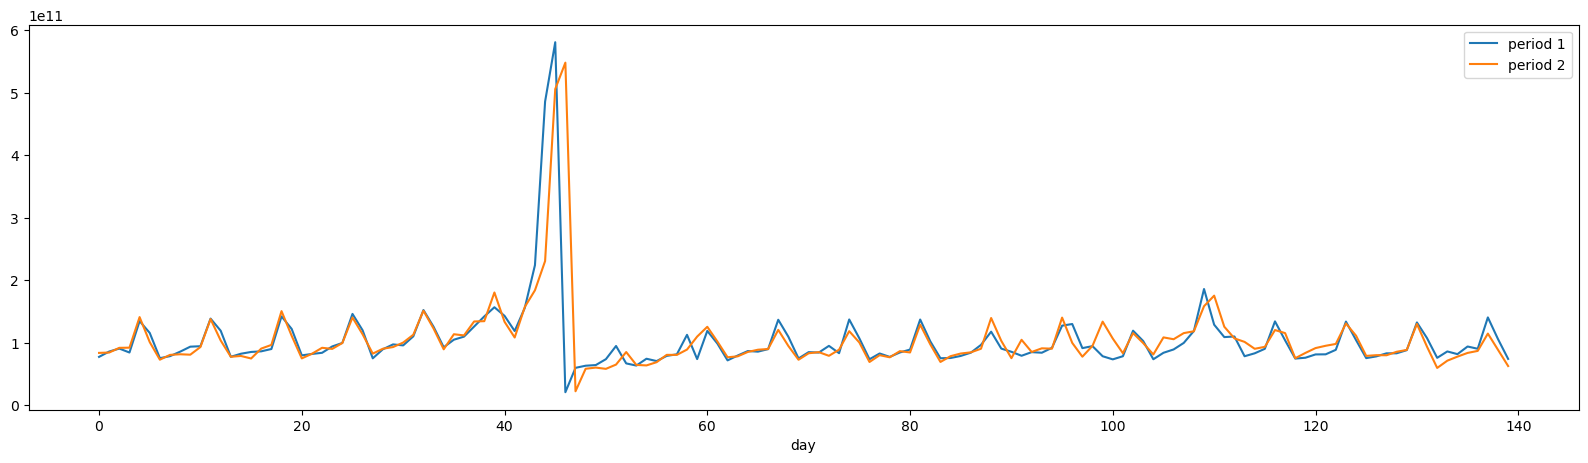

In [69]:
#set figure size
plt.figure(figsize=(20, 5))
#new_df[new_df['period_code']==1].groupby(['day'])['total_revenue'].sum().plot(kind='line')
new_df[new_df['period_code']==2].groupby(['day'])['total_revenue'].sum().plot(kind='line')
#new_df[new_df['period_code']==3].groupby(['day'])['total_revenue'].sum().plot(kind='line')
new_df[new_df['period_code']==4].groupby(['day'])['total_revenue'].sum().plot(kind='line')
plt.legend(['period 1', 'period 2', 'period 3', 'period 4'])


In [74]:
new_df[new_df['period_code']==4].describe()


,index,period_code,num_customers,total_revenue,week,day,treatment,post,treatment_post,week_post,week_post_treatment
count,8.034850e+05,803485.0,803485.000000,8.034850e+05,803485.000000,803485.000000,803485.0,803485.0,803485.0,803485.000000,803485.000000
mean,2.851224e+06,4.0,5837.832045,1.823556e+07,10.406619,68.773927,1.0,1.0,1.0,10.406619,10.406619
std,2.319463e+05,0.0,771.850118,7.013794e+06,5.779508,40.503438,0.0,0.0,0.0,5.779508,5.779508
min,2.449482e+06,4.0,2754.000000,8.122091e+06,1.000000,0.000000,1.0,1.0,1.0,1.000000,1.000000
25%,2.650353e+06,4.0,5476.000000,1.473365e+07,5.000000,33.000000,1.0,1.0,1.0,5.000000,5.000000
50%,2.851224e+06,4.0,5860.000000,1.612309e+07,10.000000,69.000000,1.0,1.0,1.0,10.000000,10.000000
75%,3.052095e+06,4.0,6120.000000,1.977348e+07,15.000000,104.000000,1.0,1.0,1.0,15.000000,15.000000
max,3.252966e+06,4.0,9147.000000,5.991774e+07,20.000000,139.000000,1.0,1.0,1.0,20.000000,20.000000


In [53]:
new_df[new_df['period_code']==2].describe()

,index,period_code,num_customers,total_revenue,week,treatment,post,treatment_post,week_post,week_post_treatment
count,8.215680e+05,821568.0,821568.000000,8.215680e+05,821568.000000,821568.0,821568.0,821568.0,821568.000000,821568.0
mean,1.240936e+06,2.0,5966.246611,1.765755e+07,10.529954,0.0,1.0,0.0,10.529954,0.0
std,2.371664e+05,0.0,790.146975,6.823978e+06,5.815897,0.0,0.0,0.0,5.815897,0.0
min,8.301520e+05,2.0,2675.000000,7.791102e+06,1.000000,0.0,1.0,0.0,1.000000,0.0
25%,1.035544e+06,2.0,5635.000000,1.424008e+07,5.000000,0.0,1.0,0.0,5.000000,0.0
50%,1.240936e+06,2.0,5928.000000,1.534727e+07,11.000000,0.0,1.0,0.0,11.000000,0.0
75%,1.446327e+06,2.0,6254.000000,1.944292e+07,16.000000,0.0,1.0,0.0,16.000000,0.0
max,1.651719e+06,2.0,9732.000000,5.967514e+07,20.000000,0.0,1.0,0.0,20.000000,0.0


In [23]:
new_df['total_revenue'][new_df['period_code'] == 1].sum(),new_df['total_revenue'][new_df['period_code'] == 2].sum(),new_df['total_revenue'][new_df['period_code'] == 3].sum(),new_df['total_revenue'][new_df['period_code'] == 4].sum()

(12241121560224.443,
 14506874975126.023,
 11662148113769.027,
 14651996827597.912)

DID for data aggregated per week

In [72]:
#aggregate df_new by week
new = new_df.groupby(['week']).agg({'num_customers': 'sum', 'total_revenue': 'sum', 'post': 'max', 'treatment': 'max', 'treatment_post': 'max', 'week_post': 'max', 'week_post_treatment': 'max'})


# fit a linear regression model with the interaction term and other covariates
X = new[['post', 'treatment','treatment_post', 'week_post','week_post_treatment']]
X = sm.add_constant(X)
y = new['total_revenue'] 
model1 = sm.OLS(y, X).fit()

# print the regression results
print(model1.summary())




                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.056
Method:                 Least Squares   F-statistic:                 3.255e-05
Date:                Mon, 24 Apr 2023   Prob (F-statistic):              0.996
Time:                        16:44:49   Log-Likelihood:                -563.86
No. Observations:                  20   AIC:                             1132.
Df Residuals:                      18   BIC:                             1134.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
post                  8.84e+11   6

In [73]:

# fit a linear regression model with the interaction term and other covariates
X = new[['post', 'treatment','treatment_post', 'week_post','week_post_treatment']]
X = sm.add_constant(X)
y = new['num_customers'] 
model2 = sm.OLS(y, X).fit()

# print the regression results
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:          num_customers   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.020
Date:                Mon, 24 Apr 2023   Prob (F-statistic):              0.326
Time:                        16:44:58   Log-Likelihood:                -386.59
No. Observations:                  20   AIC:                             777.2
Df Residuals:                      18   BIC:                             779.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
post                 3.104e+08    

Difference in differences for revenue and number of visits per customer

In [120]:
#count rows per group in  pandas groupby object after groupby
df

,store_code,date_code,period_code,redeemer_latest_ind,customer_code,customer_segment_level_1_code,customer_segment_level_2_code,revenue_after_discount_incl_vat,quantity_sold,store_type_new
3107293,263,2020-06-29,1,0,757030,2.0,3.0,1849.0,2.000,Hypermarket
2558212,242,2020-06-30,1,0,1312150,2.0,3.0,1242.0,6.616,Hypermarket
2819253,321,2020-07-01,1,0,1101810,2.0,3.0,1330.0,8.000,Daily
2523348,261,2020-07-01,1,0,1242320,2.0,3.0,1586.0,11.000,Hypermarket
453508,224,2020-07-02,1,0,774690,NaN,NaN,1414.0,5.000,Hypermarket
...,...,...,...,...,...,...,...,...,...,...
2230669,217,2022-03-31,4,0,873030,NaN,NaN,2573.0,3.174,Hypermarket
1444123,395,2022-04-01,4,0,896160,NaN,NaN,4955.0,3.000,Hypermarket
2264786,307,2022-04-01,4,0,56510,NaN,NaN,397.0,2.000,Daily
2849323,246,2022-04-02,4,0,1219500,2.0,3.0,4646.0,11.012,Hypermarket


In [121]:
#choose only rows for which customer_code is present in all 4 periods
df_per_cust = df[df['customer_code'].isin(df.groupby('customer_code').size()[df.groupby('customer_code').size() == 4].index)]
#aggregate df per customer and per period code
df_per_cust = df_per_cust.groupby(['customer_code','period_code']).agg({'customer_code':'min','period_code':'min','revenue_after_discount_incl_vat':'sum','quantity_sold':'sum','customer_segment_level_1_code':'count'})

# Rename the aggregated columns
df_per_cust = df_per_cust.rename(columns={'revenue_after_discount_incl_vat': 'total_revenue', 'quantity_sold':'total_quantity_sold', 'customer_segment_level_1_code':'nr_of_visits'})

df_per_cust['treatment'] = ((df_per_cust['period_code'] == 3) | (df_per_cust['period_code'] == 4)).astype(int)

# create a binary indicator column for the post-treatment period
df_per_cust['post'] = ((df_per_cust['period_code'] == 2) | (df_per_cust['period_code'] == 4)).astype(int)


# create an interaction term between treatment and post
df_per_cust['treatment_post'] = df_per_cust['treatment'] * df_per_cust['post']


In [100]:

# fit a linear regression model with the interaction term and other covariates
X = df_per_cust[['post', 'treatment','treatment_post']]
X = sm.add_constant(X)
y = df_per_cust['total_revenue'] 
model = sm.OLS(y, X).fit()

# print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3160
Date:                Mon, 24 Apr 2023   Prob (F-statistic):              0.814
Time:                        17:19:56   Log-Likelihood:                -6790.1
No. Observations:                 687   AIC:                         1.359e+04
Df Residuals:                     683   BIC:                         1.361e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2325.5690    360.721      6.

In [101]:

# fit a linear regression model with the interaction term and other covariates
X = df_per_cust[['post', 'treatment','treatment_post']]
X = sm.add_constant(X)
y = df_per_cust['nr_of_visits'] 
model = sm.OLS(y, X).fit()

# print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           nr_of_visits   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.258
Date:                Mon, 24 Apr 2023   Prob (F-statistic):              0.288
Time:                        17:20:12   Log-Likelihood:                -334.96
No. Observations:                 687   AIC:                             677.9
Df Residuals:                     683   BIC:                             696.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.1092      0.030     37.

The use of difference-in-differences (DiD) estimation with a low R-squared to assess treatment effects is not ideal, but it is not necessarily invalid.

In DiD analysis, the R-squared value measures the goodness of fit of the model, which shows how well the model fits the data. A low R-squared value implies that the model does not explain much of the variation in the outcome variable. However, a low R-squared does not necessarily imply that the treatment effect estimate is biased or inaccurate.

It is possible that the treatment effect is significant even when the R-squared value is low, as long as the DiD design is correctly specified, and the treatment group and control group are comparable. In some cases, a low R-squared value may indicate that there are unobserved variables affecting the outcome variable, which could lead to omitted variable bias.

Therefore, it is important to interpret the results of DiD analysis with caution and consider the limitations of the model, including the low R-squared value. It is also recommended to conduct robustness checks and sensitivity analyses to test the validity of the results.

Difference in differences for revenue and number of visits per customer per week

In [122]:
#choose only rows for which customer_code is present in all 4 periods
df_per_cust_week = df[df['customer_code'].isin(df.groupby('customer_code').size()[df.groupby('customer_code').size() == 4].index)]


#Apply the get_week function to each row in the DataFrame
week_df['week'] = week_df.apply(lambda x: get_week(x['date_code'], x['period_code']), axis=1)

# Merge the week column back into the new_df DataFrame
df_per_cust_week = pd.merge(df_per_cust_week, week_df[['date_code', 'period_code', 'week']], on=['date_code', 'period_code'])
#aggregate df per customer and per period code and week
df_per_cust_week = df_per_cust_week.groupby(['customer_code','period_code','week']).agg({'customer_code':'min','period_code':'min','revenue_after_discount_incl_vat':'sum','quantity_sold':'sum', 'week':'min', 'customer_segment_level_1_code':'count'})
# Rename the aggregated columns
df_per_cust_week = df_per_cust_week.rename(columns={'revenue_after_discount_incl_vat': 'total_revenue', 'quantity_sold':'total_quantity_sold', 'customer_segment_level_1_code':'nr_of_visits'})

df_per_cust_week['treatment'] = ((df_per_cust_week['period_code'] == 3) | (df_per_cust_week['period_code'] == 4)).astype(int)

# create a binary indicator column for the post-treatment period
df_per_cust_week['post'] = ((df_per_cust_week['period_code'] == 2) | (df_per_cust_week['period_code'] == 4)).astype(int)


# create an interaction term between treatment and post
df_per_cust_week['treatment_post'] = df_per_cust_week['treatment'] * df_per_cust_week['post']

# create an interaction term between treatment and post
df_per_cust_week['week_post'] = df_per_cust_week['week'] * df_per_cust_week['post']

# create an interaction term between treatment and post
df_per_cust_week['week_post_treatment'] = df_per_cust_week['week'] * df_per_cust_week['treatment_post']


In [123]:

# fit a linear regression model with the interaction term and other covariates
X = df_per_cust_week[['post', 'treatment','treatment_post', 'week_post','week_post_treatment']]
X = sm.add_constant(X)
y = df_per_cust_week['total_revenue']
model = sm.OLS(y, X).fit()

# print the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.6004
Date:                Mon, 24 Apr 2023   Prob (F-statistic):              0.700
Time:                        17:48:08   Log-Likelihood:                -13800.
No. Observations:                 752   AIC:                         2.761e+04
Df Residuals:                     746   BIC:                         2.764e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.259e+07   1

In [125]:

# fit a linear regression model with the interaction term and other covariates
X = df_per_cust_week[['post', 'treatment','treatment_post', 'week_post','week_post_treatment']]
X = sm.add_constant(X)
y = df_per_cust_week['nr_of_visits']
model = sm.OLS(y, X).fit()

# print the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           nr_of_visits   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.988
Date:                Mon, 24 Apr 2023   Prob (F-statistic):             0.0783
Time:                        17:48:30   Log-Likelihood:                -7078.1
No. Observations:                 752   AIC:                         1.417e+04
Df Residuals:                     746   BIC:                         1.420e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3885.1771    